In [192]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [249]:
train_data = datasets.MNIST(root="/data", download=True, train=True, transform=ToTensor())
test_data = datasets.MNIST(root="/data", train=False, download=True, transform=ToTensor())

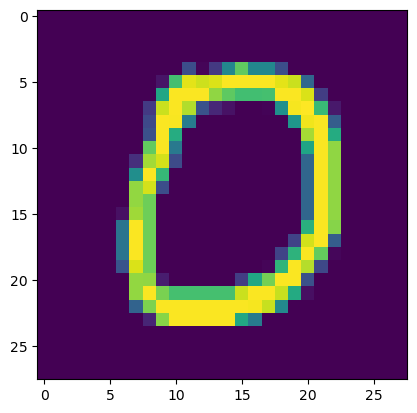

In [250]:
# dataset object contains (PIL Image, label) pairs
plt.imshow(test_data.__getitem__(10)[0].reshape(28,28))

In [251]:
bs = 32
train_dataloader = DataLoader(train_data, batch_size=bs, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=bs, shuffle=True)

In [252]:
# Making an iterator out of a dataloader object returns an iterator
# retrieving batch tensors of (batch_size, data_dim), (batch_size) (1-dim label)
data_iter = iter(train_dataloader)
train_features, train_labels = next(data_iter)
img = train_features[0].squeeze() # Crush redundant dim

In [253]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


In [254]:
# model
class MyNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(28*28, 100)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu1(x)
        logits = self.fc2(x)
        return logits

In [255]:
model = MyNetwork().to(device)

In [257]:
learning_rate = 1e-2
epochs = 5

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())
train_dataloader.dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [258]:
optimizer.zero_grad()
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset) # you can call len on this
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        prediction = model(X)
        loss = loss_fn(prediction, y)

        # backprop
        optimizer.zero_grad() # zero grads
        loss.backward()       # accumulate grads
        optimizer.step()      # take gradient descent step

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d} / {size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    for (X, y) in dataloader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            prediction = model(X)
            loss = loss_fn(prediction, y)
            test_loss += loss.item()
            correct += (prediction.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}% Avg loss: {test_loss:>8f} \n")

In [239]:
# train
for epoch in range(epochs):
    print(f"Beginning of epoch {epoch}")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Finished training")

Beginning of epoch 0
loss: 0.055693 [    0 / 60000]
loss: 0.052837 [ 6400 / 60000]
loss: 0.023599 [12800 / 60000]
loss: 0.115133 [19200 / 60000]
loss: 0.016677 [25600 / 60000]
loss: 0.048215 [32000 / 60000]
loss: 0.017355 [38400 / 60000]
loss: 0.138398 [44800 / 60000]
loss: 0.067305 [51200 / 60000]
loss: 0.064794 [57600 / 60000]
Test Error: 
 Accuracy: 97.4% Avg loss: 0.083370 

Beginning of epoch 1
loss: 0.014096 [    0 / 60000]
loss: 0.079831 [ 6400 / 60000]
loss: 0.037978 [12800 / 60000]
loss: 0.025076 [19200 / 60000]
loss: 0.085502 [25600 / 60000]
loss: 0.160246 [32000 / 60000]
loss: 0.101825 [38400 / 60000]
loss: 0.046185 [44800 / 60000]
loss: 0.078809 [51200 / 60000]
loss: 0.038848 [57600 / 60000]
Test Error: 
 Accuracy: 97.5% Avg loss: 0.080647 

Beginning of epoch 2
loss: 0.074515 [    0 / 60000]
loss: 0.079963 [ 6400 / 60000]
loss: 0.020363 [12800 / 60000]
loss: 0.028507 [19200 / 60000]
loss: 0.026666 [25600 / 60000]
loss: 0.051270 [32000 / 60000]
loss: 0.058559 [38400 / 60000

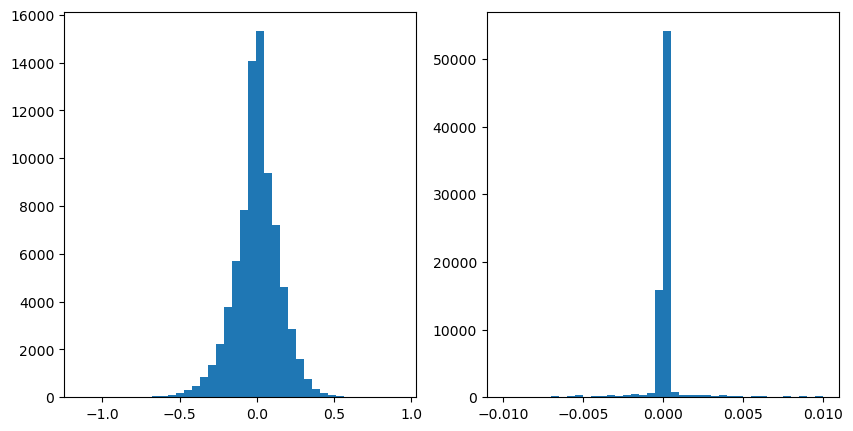

In [244]:
cpu_params = [x.cpu() for x in model.parameters()]
cpu_grads = [(x.grad).cpu() for x in model.parameters()]

with torch.no_grad():
    params = torch.concat([torch.flatten(x) for x in cpu_params])
    grads = torch.concat([torch.flatten(x) for x in cpu_grads])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(params, bins=40)
ax2.hist(grads, bins=40, range=(-1e-2, 1e-2))
plt.show()

In [335]:
class myConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2) # (1, 28, 28) -> (6, 28, 28)
        self.avg_pool1 = nn.AvgPool2d(2)           # (6, 28, 28) -> (6, 14, 14)
        self.conv2 = nn.Conv2d(6, 16, 5)           # (6, 14, 14) -> (16, 10, 10)
        self.avg_pool2 = nn.AvgPool2d(2)            # (16, 10, 10) -> (16, 5, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 128)      # (16, 5, 5) -> 120
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)              # 120 -> 10
        self.fc3 = nn.Linear(64, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.avg_pool1(x)
        x = self.conv2(x)
        x = self.avg_pool2(x)
        x = self.relu(self.fc1(x.reshape(-1, 16 * 5 * 5)))
        x = self.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

In [336]:
conv_model = myConvNet().to(device)
"""
X = torch.randn(1, 28, 28)
softmax = nn.Softmax(0)
with torch.no_grad():
    pred = conv_model(X)
    print(softmax(pred))
"""

'\nX = torch.randn(1, 28, 28)\nsoftmax = nn.Softmax(0)\nwith torch.no_grad():\n    pred = conv_model(X)\n    print(softmax(pred))\n'

In [337]:
conv_loss = nn.CrossEntropyLoss()
conv_optim = torch.optim.Adam(conv_model.parameters())

In [338]:
for epoch in range(epochs):
    print(f"Beginning of epoch {epoch}")
    train(train_dataloader, conv_model, conv_loss, conv_optim)
    test(test_dataloader, conv_model, conv_loss)
print("Finished training")

Beginning of epoch 0
loss: 2.299733 [    0 / 60000]
loss: 0.617626 [ 3200 / 60000]
loss: 0.573116 [ 6400 / 60000]
loss: 0.145199 [ 9600 / 60000]
loss: 0.382670 [12800 / 60000]
loss: 0.284393 [16000 / 60000]
loss: 0.139285 [19200 / 60000]
loss: 0.045530 [22400 / 60000]
loss: 0.237496 [25600 / 60000]
loss: 0.079974 [28800 / 60000]
loss: 0.045839 [32000 / 60000]
loss: 0.020477 [35200 / 60000]
loss: 0.115798 [38400 / 60000]
loss: 0.167810 [41600 / 60000]
loss: 0.132332 [44800 / 60000]
loss: 0.146535 [48000 / 60000]
loss: 0.137280 [51200 / 60000]
loss: 0.036943 [54400 / 60000]
loss: 0.197895 [57600 / 60000]
Test Error: 
 Accuracy: 96.1% Avg loss: 0.119429 

Beginning of epoch 1
loss: 0.070662 [    0 / 60000]
loss: 0.157237 [ 3200 / 60000]
loss: 0.110988 [ 6400 / 60000]
loss: 0.147215 [ 9600 / 60000]
loss: 0.120296 [12800 / 60000]
loss: 0.075157 [16000 / 60000]
loss: 0.060083 [19200 / 60000]
loss: 0.082967 [22400 / 60000]
loss: 0.065125 [25600 / 60000]
loss: 0.087120 [28800 / 60000]
loss: 0.

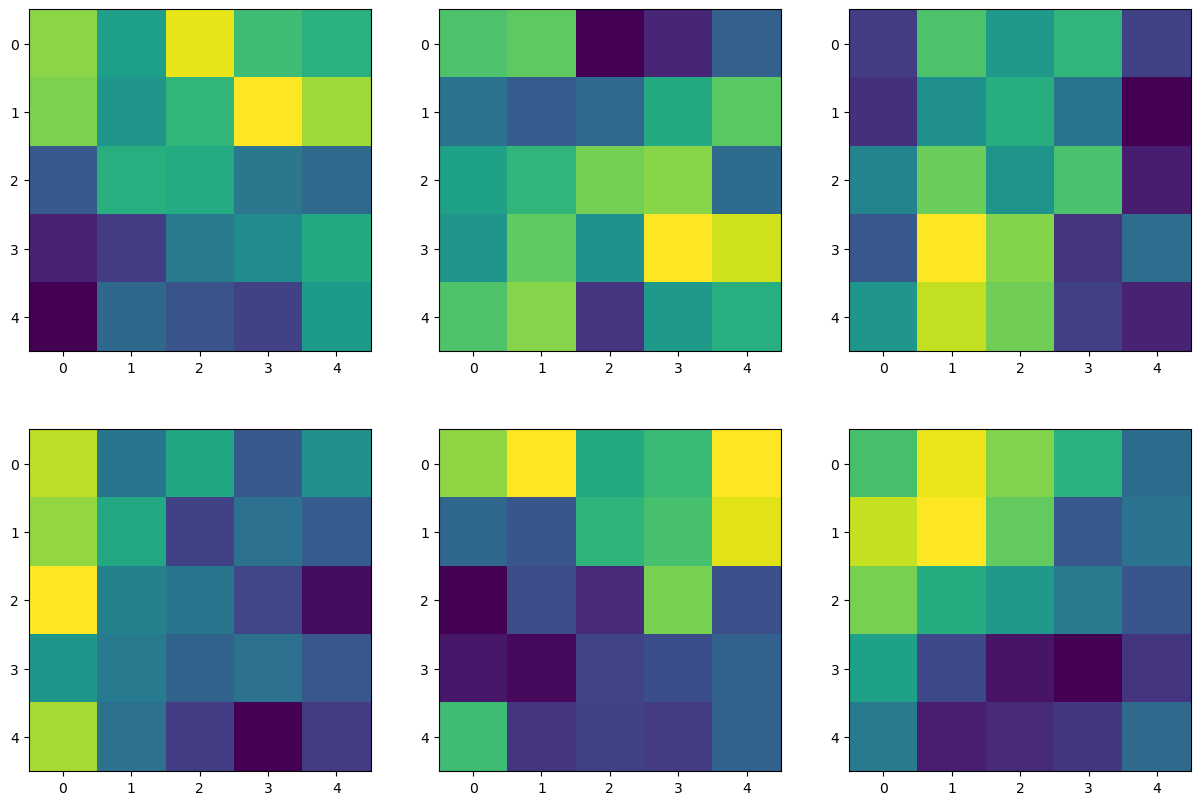

In [330]:
import numpy as np
ffilters = [x for x in conv_model.conv1.parameters()]
ffilters = [x.cpu().detach() for x in ffilters[0].squeeze()]
rows, cols = 2, 3
fig, axs = plt.subplots(rows, cols, figsize=(15,10))
for i in range(rows):
    for j in range(cols):
        axs[i, j].imshow(ffilters[i*cols + j])

In [331]:
tfilters = [x.cpu().detach().squeeze() for x in conv_model.conv2.parameters()]
tfilters[0].shape
tfilters = tfilters[0] + tfilters[1].reshape(16,1,1,1)

In [332]:
def visualize_filter(filter_num):
    fig2, ax2 = plt.subplots(rows, cols, figsize=(15,10))
    for i in range(rows):
        for j in range(cols):
            ax2[i, j].imshow(tfilters[filter_num, i*cols + j, :, :].reshape(5, 5))
    plt.show()

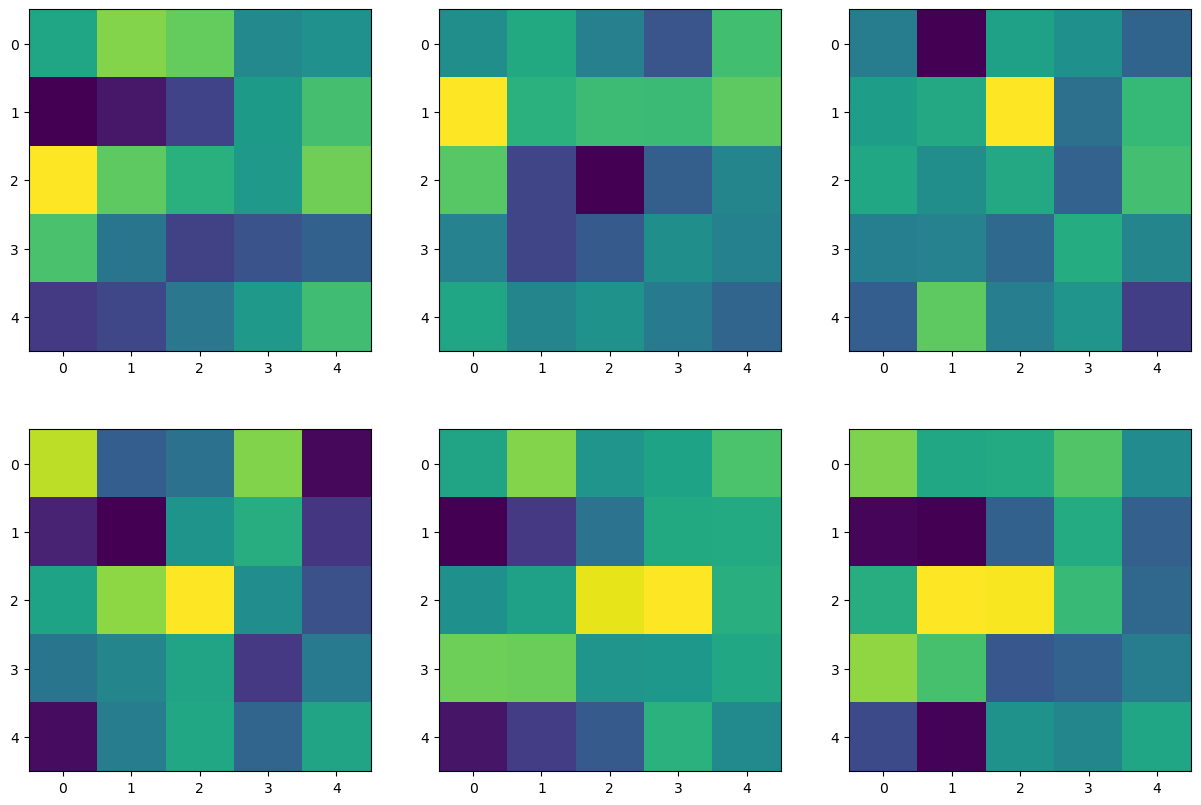

In [334]:
visualize_filter(10)